### (WIP) Sustained Attention Response Time (SART) ERP analysis: peak detection and ERP identification
The process of semi-automatically detecting peaks and telling the program whether the peaks are identified as correct ERPs or not. In case ERPs detected are right, the program moves to the next subject, but in case they are not, the user can manually set the ERPs.

In [1]:
# Import packages
import mne, os
import numpy as np
from cmath import nan
import matplotlib.pyplot as plt
import pandas as pd

# Set the default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')
mne.set_log_level('error')

# Import functions
import basic.arrange_data as arrange
import signal_processing.erp_analysis as erpan

Define these variables!

In [11]:
# Folder where to get the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the results and plots
results_foldername = 'Results/'

# Sub-folder for the experiment (i.e. timepoint or group) and its acronym
exp_folder = 'LEISURE/T1/SART'
exp_condition = 'SART_T1'

tminmax = [-200, 1000]

# Time windows for different ERP components
# {'ERP_name' : [t1, t2, pos/neg]}
erp_wins = {'N2' : [180, 350, -1],
            'P3' : [270, 500, 1]}

# Channel of interest
channel_picks = 'Cz'

# Event names (i.e. different stimuli) within the epochs
event_list = ['GO trial', 'NO-GO trial']

Run this to set the folders for data.

In [3]:
# Get directories of clean EEG files and set export directory
dir_inprogress = os.path.join(clean_folder, exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')

Files in Data/Clean/LEISURE/T1/SART read in: 4


Run this to detect and identify ERP components.

GO trial for HBA_0001_SART_T1 (0/4)


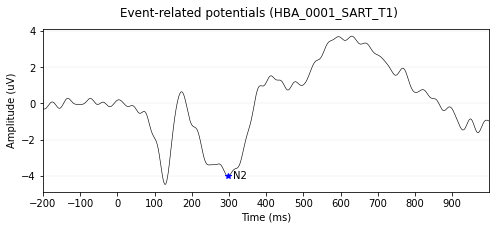

ERPs have been found and added to the dataframe for HBA_0001_SART_T1


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875,NaN,-4.050822,NaN,GO trial,Cz


NO-GO trial for HBA_0001_SART_T1 (0/4)


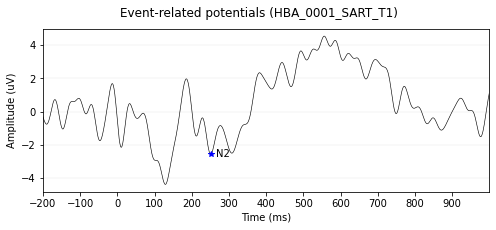

ERPs have been found and added to the dataframe for HBA_0001_SART_T1


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875000,NaN,-4.050822,NaN,GO trial,Cz
HBA_0001_SART_T1,250.976562,NaN,-2.572810,NaN,NO-GO trial,Cz


GO trial for HBA_0003_SART_T1 (1/4)


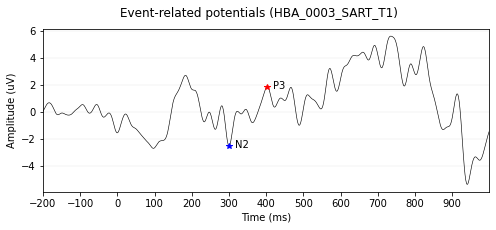

ERPs have been found and added to the dataframe for HBA_0003_SART_T1


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875000,NaN,-4.050822,NaN,GO trial,Cz
HBA_0001_SART_T1,250.976562,NaN,-2.572810,NaN,NO-GO trial,Cz
HBA_0003_SART_T1,300.781250,403.320312,-2.517506,1.856077,GO trial,Cz


NO-GO trial for HBA_0003_SART_T1 (1/4)


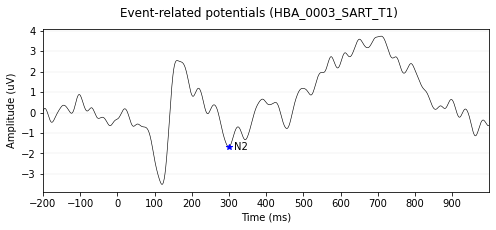

ERPs have been found and added to the dataframe for HBA_0003_SART_T1


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875000,NaN,-4.050822,NaN,GO trial,Cz
HBA_0001_SART_T1,250.976562,NaN,-2.572810,NaN,NO-GO trial,Cz
HBA_0003_SART_T1,300.781250,403.320312,-2.517506,1.856077,GO trial,Cz
HBA_0003_SART_T1,299.804688,NaN,-1.683058,NaN,NO-GO trial,Cz


GO trial for HBA_0004_SART_T1 (2/4)


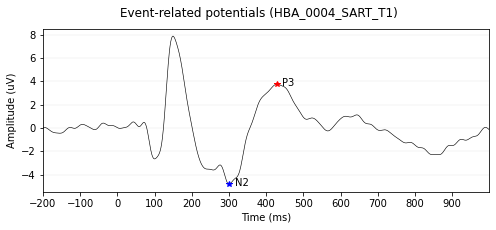

ERPs have been found and added to the dataframe for HBA_0004_SART_T1


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875000,NaN,-4.050822,NaN,GO trial,Cz
HBA_0001_SART_T1,250.976562,NaN,-2.572810,NaN,NO-GO trial,Cz
HBA_0003_SART_T1,300.781250,403.320312,-2.517506,1.856077,GO trial,Cz
HBA_0003_SART_T1,299.804688,NaN,-1.683058,NaN,NO-GO trial,Cz
HBA_0004_SART_T1,300.781250,428.710938,-4.841619,3.745975,GO trial,Cz


NO-GO trial for HBA_0004_SART_T1 (2/4)


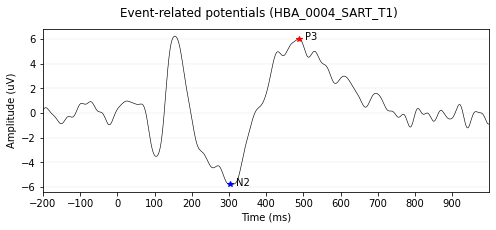

ERPs have been found and added to the dataframe for HBA_0004_SART_T1


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875000,NaN,-4.050822,NaN,GO trial,Cz
HBA_0001_SART_T1,250.976562,NaN,-2.572810,NaN,NO-GO trial,Cz
HBA_0003_SART_T1,300.781250,403.320312,-2.517506,1.856077,GO trial,Cz
HBA_0003_SART_T1,299.804688,NaN,-1.683058,NaN,NO-GO trial,Cz
HBA_0004_SART_T1,300.781250,428.710938,-4.841619,3.745975,GO trial,Cz
HBA_0004_SART_T1,302.734375,488.281250,-5.779026,6.044084,NO-GO trial,Cz


GO trial for HBA_0005_SART_T1 (3/4)


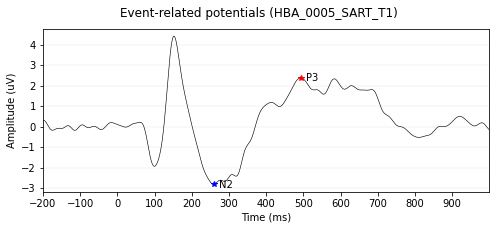

ERPs have been found and added to the dataframe for HBA_0005_SART_T1


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875000,NaN,-4.050822,NaN,GO trial,Cz
HBA_0001_SART_T1,250.976562,NaN,-2.572810,NaN,NO-GO trial,Cz
HBA_0003_SART_T1,300.781250,403.320312,-2.517506,1.856077,GO trial,Cz
HBA_0003_SART_T1,299.804688,NaN,-1.683058,NaN,NO-GO trial,Cz
HBA_0004_SART_T1,300.781250,428.710938,-4.841619,3.745975,GO trial,Cz
HBA_0004_SART_T1,302.734375,488.281250,-5.779026,6.044084,NO-GO trial,Cz
HBA_0005_SART_T1,258.789062,493.164062,-2.811082,2.376620,GO trial,Cz


NO-GO trial for HBA_0005_SART_T1 (3/4)


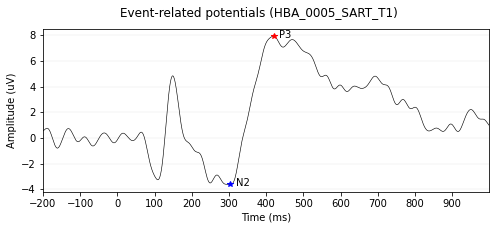

ERPs have been found and added to the dataframe for HBA_0005_SART_T1


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875000,NaN,-4.050822,NaN,GO trial,Cz
HBA_0001_SART_T1,250.976562,NaN,-2.572810,NaN,NO-GO trial,Cz
HBA_0003_SART_T1,300.781250,403.320312,-2.517506,1.856077,GO trial,Cz
HBA_0003_SART_T1,299.804688,NaN,-1.683058,NaN,NO-GO trial,Cz
HBA_0004_SART_T1,300.781250,428.710938,-4.841619,3.745975,GO trial,Cz
HBA_0004_SART_T1,302.734375,488.281250,-5.779026,6.044084,NO-GO trial,Cz
HBA_0005_SART_T1,258.789062,493.164062,-2.811082,2.376620,GO trial,Cz
HBA_0005_SART_T1,303.710938,419.921875,-3.622827,7.938980,NO-GO trial,Cz


,N2 latency,P3 latency,N2 amplitude,P3 amplitude,Event,Channel
HBA_0001_SART_T1,296.875000,NaN,-4.050822,NaN,GO trial,Cz
HBA_0001_SART_T1,250.976562,NaN,-2.572810,NaN,NO-GO trial,Cz
HBA_0003_SART_T1,300.781250,403.320312,-2.517506,1.856077,GO trial,Cz
HBA_0003_SART_T1,299.804688,NaN,-1.683058,NaN,NO-GO trial,Cz
HBA_0004_SART_T1,300.781250,428.710938,-4.841619,3.745975,GO trial,Cz
HBA_0004_SART_T1,302.734375,488.281250,-5.779026,6.044084,NO-GO trial,Cz
HBA_0005_SART_T1,258.789062,493.164062,-2.811082,2.376620,GO trial,Cz
HBA_0005_SART_T1,303.710938,419.921875,-3.622827,7.938980,NO-GO trial,Cz


In [13]:
# Loop through all the subjects' directories (EEG files directories)
df_erps = pd.DataFrame()
arrange.create_results_folders(exp_folder=exp_folder,results_folder=results_foldername, erps=True)
for i in range(len(file_dirs)):
    erp_wins_temp = erp_wins
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]), verbose=False)
    
    # Apply baseline correction
    epochs = epochs.apply_baseline(baseline=(None, 0))

    ### create loop here for going through GO and NO-GO's separately
    for ev in event_list:
        print('{} for {} ({}/{})'.format(ev, subject_names[i], i, len(file_dirs)))
        # Create an averaged evoked object from epochs
        evoked_signal = epochs[ev].average(picks=channel_picks)

        # remove or add if save_evoked === truuuu
        evoked_signal.save('{}/{}/ERP analysis/{}_{}_{}_evoked-ave.fif'.format(results_foldername, exp_folder,
                                                                            subject_names[i], channel_picks,
                                                                            ev), overwrite=True)

        # Find all the peaks in the evoked signal
        minpeak_times, minpeak_mags, maxpeak_times, maxpeak_mags = erpan.find_all_peaks(evoked_signal, epochs, 
                                                                                        t_range=tminmax, thresh=None,
                                                                                        subject_name=subject_names[i],
                                                                                        verbose=False, plot=False)
        
        # Identify which peaks are which ERPs based on the pre-defined ERP time windows
        erp_peaks, not_erp_peaks = erpan.identify_erps(evoked_signal, erp_wins_temp, minpeak_times, minpeak_mags,
                                                    maxpeak_times, maxpeak_mags, t_range=tminmax, subject_name=subject_names[i],
                                                    verbose=False, plot=True, savefig=False,
                                                    results_foldername=results_foldername, exp_folder=exp_folder)

        # After visual inspection, it's possible to re-define the time windows to look for the peak
        while input('Do you need to do any manual time window changes? (leave empty if "no")') != '':
            print('Changing time window parameters for {}'.format(subject_names[i]))
            new_time_win = [None, None, None]

            # Ask user for which ERP they want to change or add
            erp_tochange = input('What ERP time window you want to change (e.g., N1)?')

            # Ask user what should be the minimum timepoint of the time window for that ERP
            new_time_win[0] = int(input('Enter MIN time of the window in interest for {} (e.g., 50)'.format(erp_tochange)))

            # Ask user what should be the maximum timepoint of the time window for that ERP
            new_time_win[1] = int(input('Enter MAX time of the window in interest for {} (e.g., 100)'.format(erp_tochange)))

            # Ask user whether this ERP should be a postitive (1) or negative (-1) peak
            new_time_win[2] = int(input('Enter whether to look for MIN (-1) or MAX (1) voltage for {}'.format(erp_tochange)))

            # Change the temporary ERP time window parameters to the user inputted parameters
            erp_wins_temp[erp_tochange] = new_time_win
            print('Changing', erp_tochange, 'with new time window:', str(new_time_win))

            # Use these new parameters to find either minimum or maximum value in that range
            try:
                erp_peaks = erpan.find_minmax_erp(evoked_signal, erp_peaks, erp_tochange, new_time_win,
                                                t_range=tminmax, subject_name=subject_names[i], verbose=False, plot=True,
                                                savefig=False, results_foldername=results_foldername, exp_folder=exp_folder)
            except:
                print('Something went wrong with manual ERP detection, try again.')

        # Add this/these new temporary ERP to the main dataframe
        df_erps_temp = erpan.erp_dict_to_df(erp_peaks, erp_wins_temp, subject_names[i])
        df_erps_temp['Event'] = ev
        df_erps_temp['Channel'] = channel_picks
        df_erps = pd.concat([df_erps, df_erps_temp])
        print('ERPs have been found and added to the dataframe for {}'.format(subject_names[i]))
        display(df_erps)

# Export all the detected ERPs to an Excel spreadsheet
display(df_erps)
df_erps.to_excel('{}/{}/ERP analysis/{}_{}_grandaverage_erps.xlsx'.format(results_foldername,exp_folder,exp_condition,channel_picks))